#Housing Price Prediction
###Author: Aditya Moon
###Project Description:
#####In this project, an lgb model is trained to predict housing sale prices in the US based on 9 features: brokered_by (realtor ID), number of beds, number of baths, total acres of the property, city, state, zip code, house size, and days since the house was last sold.
#####Goal Metric: Minimize MAE (Mean Absolute Error)


---

Link to the original dataset: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

#0. Imports and Settings

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

plt.style.use("ggplot")

pd.set_option("display.width", 1000)
pd.set_option("display.expand_frame_repr", False)
pd.options.display.float_format = "{:.2f}".format
%autosave 60

Autosaving every 60 seconds


In [71]:
try:
  df = pd.read_csv("realtor-data.zip.csv")
except:
  ! pip install psycopg2-binary sqlalchemy pandas numpy matplotlib seaborn pyspark scikit-learn lightgbm kaggle
  ! kaggle datasets download "ahmedshahriarsakib/usa-real-estate-dataset" --force
  ! unzip usa-real-estate-dataset.zip
  df = pd.read_csv("realtor-data.zip.csv")

#1. General Data Understanding

In [72]:
df.sample(10)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
435126,22854.00,for_sale,525000.00,2.00,2.00,NaN,1032946.00,New Smyrna Beach,Florida,32169.00,768.00,2020-10-12
1974966,57618.00,sold,260990.00,4.00,3.00,NaN,1004802.00,Brookshire,Texas,77423.00,1851.00,2021-12-29
974787,98682.00,for_sale,320000.00,4.00,2.00,0.48,635886.00,Pineville,Louisiana,71360.00,2230.00,2013-05-13
1293339,23592.00,for_sale,639999.00,3.00,2.00,0.34,802544.00,Idyllwild,California,92549.00,1792.00,2004-09-15
690516,51289.00,for_sale,124099.00,4.00,2.00,0.14,1324607.00,Dayton,Ohio,45406.00,1300.00,2017-08-16
1569557,22611.00,sold,219900.00,3.00,2.00,0.50,70230.00,Waynesboro,Pennsylvania,17268.00,1104.00,2022-01-21
418854,72011.00,for_sale,80000.00,NaN,NaN,10.11,1284878.00,Seale,Alabama,36875.00,NaN,NaN
1987232,33745.00,sold,699900.00,4.00,4.00,0.22,864393.00,League City,Texas,77573.00,4444.00,2021-12-06
1007520,53177.00,for_sale,170000.00,4.00,3.00,0.15,1691689.00,Mooreland,Oklahoma,73852.00,2267.00,1996-09-03
1646758,10437.00,sold,430000.00,2.00,1.00,0.17,1500914.00,Atlanta,Georgia,30316.00,NaN,2022-03-04


In [73]:
df.shape

(2226382, 12)

In [74]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2221849.00,2224841.00,1745065.00,1714611.00,1900793.00,2215516.00,2226083.00,1657898.00
mean,52939.89,524195.52,3.28,2.50,15.22,1012324.92,52186.68,2714.47
std,30642.75,2138893.22,1.57,1.65,762.82,583763.48,28954.08,808163.52
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,4.00
25%,23861.00,165000.00,3.00,2.00,0.15,506312.75,29617.00,1300.00
50%,52884.00,325000.00,3.00,2.00,0.26,1012765.50,48382.00,1760.00
75%,79183.00,550000.00,4.00,3.00,0.98,1521173.25,78070.00,2413.00
max,110142.00,2147483600.00,473.00,830.00,100000.00,2001357.00,99999.00,1040400400.00


In [75]:
df.nunique()

,0
brokered_by,110143
status,3
price,102137
bed,99
bath,86
acre_lot,16057
street,2001358
city,20098
state,55
zip_code,30334


I wonder what the ratio between baths to beds is for our df...

In [76]:
x = df["bath"]/df["bed"]
x.mean()

0.7900594393639737

In [77]:
df.dtypes

,0
brokered_by,float64
status,object
price,float64
bed,float64
bath,float64
acre_lot,float64
street,float64
city,object
state,object
zip_code,float64


#2. Data Preprocessing/Understanding
###This section contains all of the data preprocessing that is needed before the ML model is trained. The data will also be further explored.


####Type switching
We're gonna switch all categorical features to the *category* data type. If you're wondering what categorical features are, they're essentially any features that involves a non-ordinal numerical relationship or features that involve string values.

In [78]:
df = df.apply(lambda col: col.astype("category") if col.dtype == "object" else col)
df["brokered_by"] = df["brokered_by"].astype("category")
df["zip_code"] = df["zip_code"].astype("category")

In [79]:
print(df["status"].unique())

['for_sale', 'ready_to_build', 'sold']
Categories (3, object): ['for_sale', 'ready_to_build', 'sold']


In [80]:
df["status"].value_counts()

,count
status,
for_sale,1389306
sold,812009
ready_to_build,25067


####Removing a few columns
Remember that the goal of our machine learning model is to be able to predict the **sold prices** of houses, not their listing prices our their ready to build prices. Therefore, we'll only keep the rows where the house has a confirmed sold price. This will also significantly reduce the size of the df, making our data easier to work with.

In [81]:
df = df.loc[df["status"] == "sold"]

We're then going to want to drop the status feature since it's no longer useful.

#####In addition, from df.nunique() above, we can see that the street column has almost as many unique streets as there are rows in the df! That feature is useless!!! Let's remove it as well.

In [82]:
df.drop(columns=["status", "street"], inplace=True)

<ipython-input-82-c5761e3372d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["status", "street"], inplace=True)


####Accounting for null values

In [83]:
df.isna().sum()

,0
brokered_by,3020
price,245
bed,69974
bath,77929
acre_lot,107622
city,98
state,0
zip_code,12
house_size,103710
prev_sold_date,0


In [84]:
df.shape

(812009, 10)

That's a LOT of null values.
##### Since these rows with null values constitute a sizeable % of our df, we should try to remove as few as we can. With the features bed and bath, they are probably highly correlated with the price feature. We can group the df by price and then apply the fillna() command onto the null values of these features.

In [85]:
df["bed"].describe().round(4)

,bed
count,742035.00
mean,3.19
std,1.30
min,1.00
25%,3.00
50%,3.00
75%,4.00
max,444.00


In [86]:
print(df.groupby(["price"]).ngroups) #Given we have 812k total rows, 34518 groups is enough for the fillna() operation

34518


In [87]:
df["bed"] = df.groupby(["price"])["bed"].transform(lambda x: x.fillna(x.mean()))


In [88]:
print(df["bed"].describe().round(4))

count   808487.00
mean         3.16
std          1.26
min          1.00
25%          2.70
50%          3.00
75%          4.00
max        444.00
Name: bed, dtype: float64


The distributrions mean changed by 0.03, but considering we added around 60k values to the bed feature, it's a good for fillna().

Now we'll do the exact same thing with the bath column:

In [89]:
print(df["bath"].describe().round(4))

count   734080.00
mean         2.39
std          1.16
min          1.00
25%          2.00
50%          2.00
75%          3.00
max        222.00
Name: bath, dtype: float64


In [90]:
df["bath"] = df.groupby(["price"])["bath"].transform(lambda x: x.fillna(x.mean()))

In [91]:
print(df["bath"].describe().round(4))

count   808347.00
mean         2.34
std          1.13
min          1.00
25%          2.00
50%          2.00
75%          3.00
max        222.00
Name: bath, dtype: float64


The mean of bath changed by 0.05 but we added around 75k values. Once again, this is a pretty good result for fillna().

You may have also noticed that the maximums for bed and bath respectively are 444 and 222! We can create an easy outlier rule right now to remove rows with bed/bath values greater than 10

In [92]:
df = df[df["bed"] <= 10]
df = df[df["bath"] <= 10]

In [93]:
print(df.isna().sum())

brokered_by         2942
price                  0
bed                    0
bath                   0
acre_lot          107398
city                  89
state                  0
zip_code              12
house_size        100225
prev_sold_date         0
dtype: int64


We'll remove the rest of the null values, given that they are harder to fill in by using another feature:

In [94]:
df.dropna(inplace=True)

In [95]:
print(df.isna().sum())

brokered_by       0
price             0
bed               0
bath              0
acre_lot          0
city              0
state             0
zip_code          0
house_size        0
prev_sold_date    0
dtype: int64


In [96]:
print(df.shape[0])

616609


####Drop Duplicates

In [97]:
df.shape

(616609, 10)

In [98]:
df.duplicated().sum()

583

In [99]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True)

,brokered_by,price,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date
0,72457.00,524900.00,3.00,2.00,0.09,Aguada,Puerto Rico,602.00,2200.00,2021-12-13
1,48586.00,175000.00,2.78,1.83,0.14,Aguadilla,Puerto Rico,603.00,3200.00,2021-11-29
2,61711.00,90000.00,3.00,2.00,0.08,Aguadilla,Puerto Rico,603.00,1421.00,2021-10-19
3,49592.00,22500.00,2.00,1.00,0.32,Anasco,Puerto Rico,610.00,850.00,2021-12-30
4,72408.00,168000.00,6.00,4.00,0.05,Anasco,Puerto Rico,610.00,3422.00,2021-10-21
...,...,...,...,...,...,...,...,...,...,...
616021,23009.00,359900.00,4.00,2.00,0.33,Richland,Washington,99354.00,3600.00,2022-03-25
616022,18208.00,350000.00,3.00,2.00,0.10,Richland,Washington,99354.00,1616.00,2022-03-25
616023,76856.00,440000.00,6.00,3.00,0.50,Richland,Washington,99354.00,3200.00,2022-03-24
616024,53618.00,179900.00,2.00,1.00,0.09,Richland,Washington,99354.00,933.00,2022-03-24


####Refactoring our prev_sold_date column
It would be better if we used the data from prev_sold_data to make numerically. We can change to "days_since_last_sold" each row's date is subtracted by the latest date we have in our dataset (February 2nd, 2024)

In [100]:
df["prev_sold_date"] = pd.to_datetime(df["prev_sold_date"], errors="coerce")

In [101]:
epoch = pd.Timestamp("2024-02-02")
df["days_since_last_sold"] = (epoch - df["prev_sold_date"]).dt.days
df["days_since_last_sold"].sample()

,days_since_last_sold
1968659,791


In [102]:
df.drop(columns="prev_sold_date", inplace=True) #Drop the column now that we don't need it

In [103]:
df.columns

Index(['brokered_by', 'price', 'bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code', 'house_size', 'days_since_last_sold'], dtype='object')

####Removing 0 values

In [104]:
print((df == 0).sum(axis=0))

brokered_by               9
price                     0
bed                       0
bath                      0
acre_lot                883
city                      0
state                     0
zip_code                  0
house_size                0
days_since_last_sold      0
dtype: int64


In [105]:
df = df[df["acre_lot"] != 0]
df = df[df["brokered_by"] != 0]

##Removing outliers

Removing outliers is an essential part to preprocessing before we train our actual ML model. But before we remove outliers, it's important to understand the goal of what we want our distribution to look like/what characteristics it should have:

1.   We should aim to create a normal distribution, or at least close to normal. This will be benefical in producing good results for our model, because if our distribution is normal then our model won't be training on data that is biased towards low/high housing prices.
2.   We should aim for our distribution to be realistic, meaning a reflection of the actual market. According to Zillow:

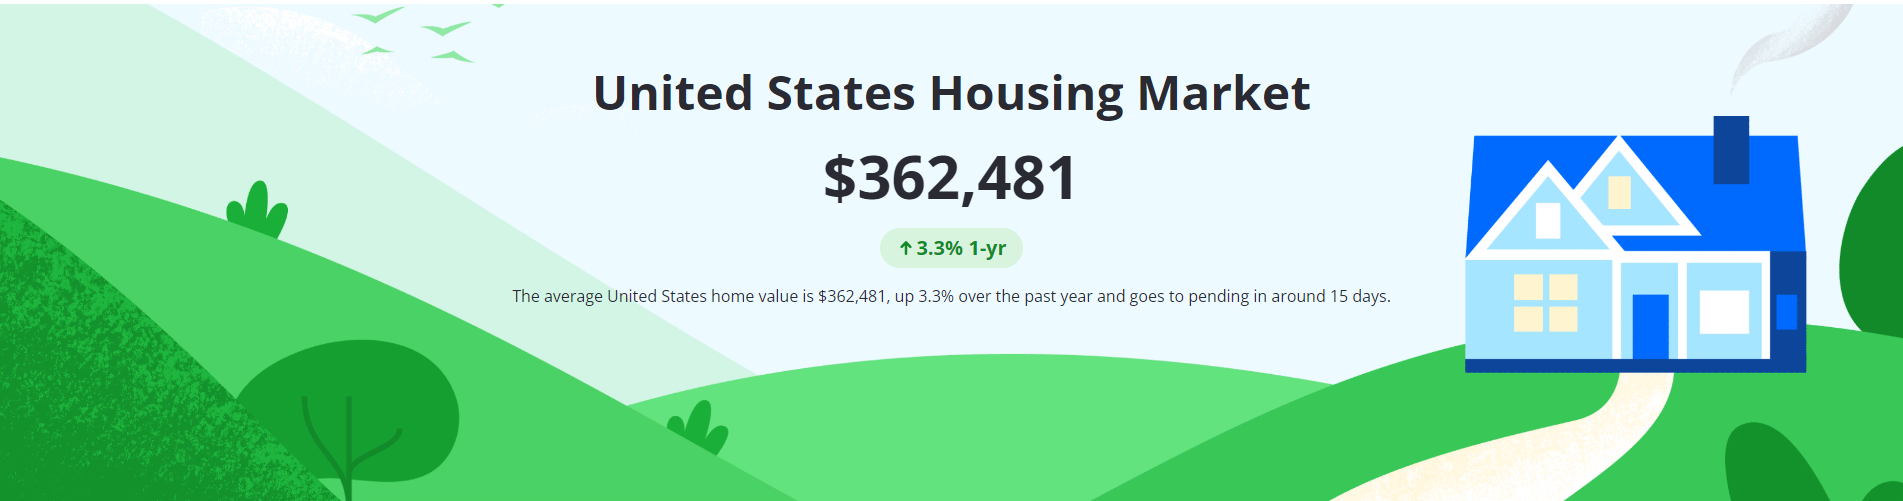

Source: https://www.zillow.com/home-values/102001/united-states/
#####We'll aim to have the average value in the price feature close to this price as well

In [106]:
# df = a.copy()

In [107]:
a = df.copy()

In [108]:
a["price"].mean()

513575.0260886246

Let's take a look at our most important feature distribution: price

In [109]:
def plot_series_value_counts_percentage_distribution(df, col, bin_size):
  price_groups = []
  num_in_each_price_group = []
  for price in range(int(df[col].min()), int(df[col].max())+bin_size, bin_size):
    percentage = len(df[(df[col] >= price - bin_size) & (df[col] <= price)]) / len(df)
    if(percentage >= 0.02):
      price_groups.append(price)
      num_in_each_price_group.append(percentage)

  price_groups[-1]-df[col].max()

  plt.figure(figsize=(10, 6))
  plt.bar(price_groups, num_in_each_price_group, width=60000)
  plt.xlabel("Price Group")
  plt.ylabel("Percentage")
  plt.xticks(price_groups, [f"{price // 1000}k" for price in price_groups])
  plt.title("Df Price Percentage Distribution")
  plt.show()

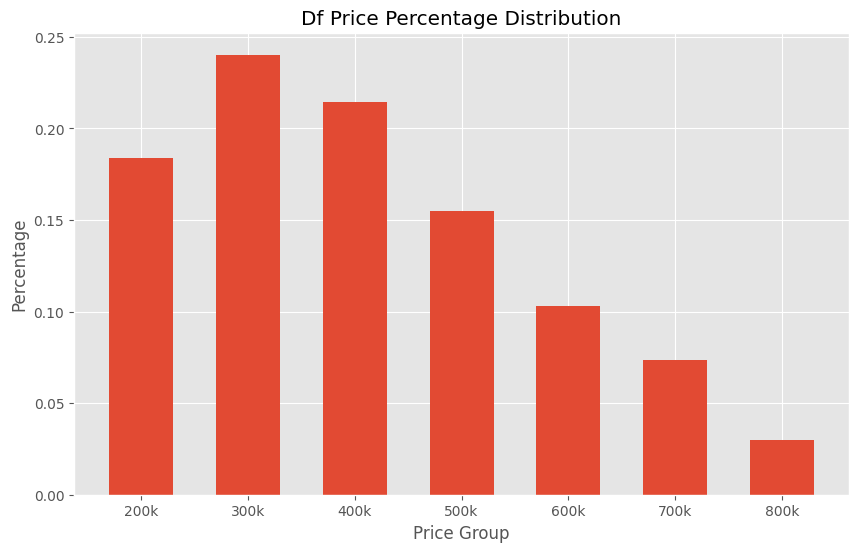

In [141]:
plot_series_value_counts_percentage_distribution(df, "price", 100000)

Based on this graph, it is clear that some rows in our dataset (below 200k-250k) are likely condos, townhouses, etc. Just an observation

Remember the 2 conditions we just talked about above. If we relate them to our current price distribution, we can see that our data is clearly right skewed, meaning it's not normal and its' average value is higher than the ~360k average we are aiming for. We can confirm this

In [111]:
df["price"].mean()

513575.0260886246

In [112]:
df.shape

(615134, 10)

Let's use the IQR method to fix this. To anyone who understands IQR well, I programmed it a little differently. Given the right skew.



*   I made the IQR larger for the right threshold
*   Our left threshold for IQR will definitely be negative, as the formula will not aim to make a right skew even more biased. However, there are values below 100k, which is not practical at all:



In [113]:
df.loc[df["price"] < 100000]

,brokered_by,price,bed,bath,acre_lot,city,state,zip_code,house_size,days_since_last_sold
1414376,61711.00,90000.00,3.00,2.00,0.08,Aguadilla,Puerto Rico,603.00,1421.00,836
1414377,49592.00,22500.00,2.00,1.00,0.32,Anasco,Puerto Rico,610.00,850.00,764
1414399,103780.00,95000.00,2.55,1.49,0.09,Sabana Grande,Puerto Rico,637.00,1603.00,835
1414400,103780.00,70000.00,2.00,1.00,2.91,Utuado,Puerto Rico,641.00,755.00,826
1414405,49045.00,95000.00,3.00,1.00,0.08,Guanica,Puerto Rico,653.00,1200.00,765
...,...,...,...,...,...,...,...,...,...,...
2224853,108321.00,99900.00,2.00,2.00,0.28,Republic,Washington,99166.00,1056.00,700
2224855,108383.00,49900.00,2.00,1.00,1.28,Republic,Washington,99166.00,896.00,722
2225552,637.00,54900.00,2.00,2.00,0.06,Spokane,Washington,99224.00,924.00,668
2225740,8200.00,90000.00,3.00,2.00,0.16,Prescott,Washington,99348.00,1624.00,785


Specifically over 70000 values over 100k.
#####We'll classify prices under 100000 as outliers and remove them. This will balance out with the fact that the right IQR threshold will be higher

In [114]:
pre_outlier_df_shape = df.shape[0]

354900.0
589900.0 235000.0
IQR: 354900.0 | Q1, Q3: (235000.0, 589900.0) | Values below 100000 or above 767350.0 will be removed from the dataframe
New df mean: 365191.0155452276
New df kurtosis: -0.5977267671968454


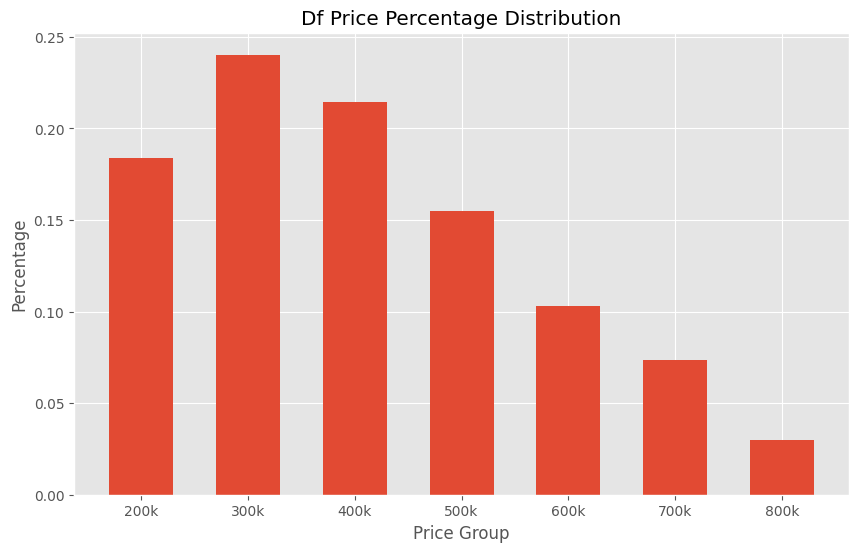

In [115]:
df = a.copy()
a = df.copy()

def iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3-Q1
  print(IQR)
  print(Q3, Q1)
  first_threshold = 100000
  second_threshold = Q3+0.5*IQR #A "higher" threshold is actually a multiplier < 1 applied to the IQR variable
  print(f"IQR: {IQR} | Q1, Q3: {Q1, Q3} | Values below {first_threshold} or above {second_threshold} will be removed from the dataframe")
  df = df[(df[column]>100000) & (df[column] < (second_threshold))]

  print(f"New df mean: {df[column].mean()}")
  print(f"New df kurtosis: {df[column].kurt()}") #test this again just test the whole function
  return df

df = iqr(df, "price").copy()
plot_series_value_counts_percentage_distribution(df, "price", 100000)

Amazing!

*   The dataframe now has a distribution close to normal, as evidenced by the kurtosis value close to 0
*   The mean price for our US housing dataframe is now 365k, practically the same as the actual mean house price in the US of 360k
*   The range of the prices is a very reasonable and practical range between 100k to 767k


In [116]:
post_outlier_df_shape = df.shape[0]
post_outlier_df_shape

493592

In [117]:
pre_outlier_df_shape - post_outlier_df_shape

121542

In [118]:
print(f"{((pre_outlier_df_shape - post_outlier_df_shape)/pre_outlier_df_shape)*100}% of the df was removed using our outlier detection method")

19.75862169868679% of the df was removed using our outlier detection method


In [119]:
df["price"].describe()

,price
count,493592.00
mean,365191.02
std,164121.08
min,100250.00
25%,235000.00
50%,340000.00
75%,475000.00
max,767340.00


#3. Machine Learning

####Brief explanation of my ML process
It may come as no surprise that this is the section I spent by far the most time on. I tried using a variety of different models, many of which were from the **scikit-learn** library. Some of the models I tried include Logistic Regression, XGBoost, Catboost, Ridge, Linear Regression, Decision Tree, and Random Forest. I ended up choosing lgb (LightGBM). Some of the other models I tried did not produce results that were as good as lgb. Ridge, for example, only achieved a MAE score of around 80000. Other models I tried I ended up not having the computing power to be able to train, such as Random Forest.
#####I also spent time on hyperparameter tuning using RandomizedSearchCV.
#####All the ML + hyperparameter tuning code is below:

In [134]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

X = df.drop(columns=["price"]).copy()
y = df[["price"]].copy()
y = y.values.ravel()

numeric_features = X.select_dtypes(include=["float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["category"]).columns.tolist()

scaler = StandardScaler() #This will cause some rows in the numerical features to be negative
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

kf = KFold(n_splits=5, shuffle=True, random_state=24)

#Commented out, given that I already have a list of best parameters

# param_list = {
#     "reg_lambda": uniform(0, 1.0),
#     "n_estimators": randint(150, 500),
#     "colsample_bytree": uniform(0.6, 0.4),
#     "min_child_samples": randint(10, 100),
#     "subsample": uniform(0.6, 0.4),
#     "learning_rate": uniform(0.1, 0.04),
#     "max_depth": randint(7, 15),
#     "num_leaves": randint(14, 30),
#     "reg_alpha": uniform(0, 1.0),
# }

# rs_cv = RandomizedSearchCV(lgb.LGBMRegressor(), param_distributions=param_dist,
#                                    scoring="neg_mean_absolute_error",
#                                    n_jobs=-1, n_iter=30, cv=5, random_state=24, verbose=1)

# rs_cv.fit(X_train, y_train)

# print(random_search.best_params_)


In [136]:
best_params = {
    "reg_lambda": 0.31880625349828406,
    "n_estimators": 445,
    "colsample_bytree": 0.6353911304922466,
    "min_child_samples": 30,
    "subsample": 0.7490748848110026,
    "learning_rate": 0.12062714059397683,
    "max_depth": 12,
    "num_leaves": 35,
    "reg_alpha": 0.3847607774222854,
    "verbosity": 0,
    "max_bin": 500
}

model = lgb.LGBMRegressor(**best_params)

cv_r2_scores = cross_val_score(model, X, y, cv=kf, error_score="raise")

#Training the model
model.fit(X_train, y_train) #Train the actual pipeline on the training data
y_pred = model.predict(X_test) #Generate predictions with the pipeline
MAE = np.mean(abs(y_pred-y_test))

test_score = model.score(X_test, y_test)
print(f"CV Score | Pipeline Test Score: {cv_r2_scores.mean()} | {test_score}")
print("\033[1m" + f"MAE: {MAE}" + "\033[0m")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured

#####The consistency between the cross validation and model R² scores shows that our model is not overfitting by the slightest.
#####Let's now take a look at our predictions vs the sale prices, side-by-side!

In [137]:
X_test["price"] = y_test

In [138]:
X_test["price_prediction"] = y_pred

In [139]:
X_test["MAE"] = abs(y_test-y_pred)

In [145]:
X_test.sample(5)

,brokered_by,bed,bath,acre_lot,city,state,zip_code,house_size,days_since_last_sold,price,price_prediction,MAE
1664293,37387.00,0.86,-0.39,-0.01,Ocala,Florida,34472.00,-0.03,-0.37,228900.00,275060.73,46160.73
1520757,52990.00,1.97,0.80,-0.01,Lake Ariel,Pennsylvania,18436.00,0.58,1.25,379000.00,369814.36,9185.64
1528421,16829.00,0.86,-0.39,-0.01,Phoenixville,Pennsylvania,19460.00,0.05,1.84,325000.00,316487.42,8512.58
1875481,60731.00,0.86,0.80,-0.01,Saint Louis,Missouri,63136.00,-0.30,1.12,124900.00,110271.81,14628.19
1797553,79237.00,-1.36,-1.57,-0.01,Des Moines,Iowa,50313.00,-0.41,-0.26,109000.00,122487.12,13487.12


# 4. Conclusion
#####A MAE score of less than \$50,000 was achieved, meaning on average, **we were able to predict the sale price of a house within $50,000 of its' actual sale price!**

#####Specifically, we achieved an R² score of 0.81. Considering the complexity of this problem, the results achieved are noteworthy.

---

# Thanks for viewing! 😁